In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from astropy.io.fits import getdata
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
from astroquery.vizier import Vizier
from astropy.table import Table
from astroquery.xmatch import XMatch
import time
import pyvo as vo
from pathlib import Path
import sys  
sys.path.insert(0, '../')
#from muwclass import datasets, prep, red,  classify, distribution, plots, prepare_data, prepare_cxo

from prepare_library import atnf_pos, create_perobs_data, cal_ave, add_MW, confusion_clean, TD_clean_vizier, Gaia_counterparts, CSC_clean_keepcols, vphasp_to_gaia_mags, Gaia_counterparts_update, create_field_csc_data, cal_PU, refsrc_gaia, cal_astrometric_correction

from muwclass_library import prepare_cols

import warnings
warnings.filterwarnings('ignore') 

Vizier.ROW_LIMIT = -1
exnum = -999999.

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
data_dir = './data/NGC3532_02182022'
field_name = 'NGC3532_02182022'
verb = 0

query_dir = '../demo/data/query'

ref_obsID = 8941
ref_mjd = 5.4762887769419E+04
ra =166.28875
dec =  -58.85
radius = 25

Path(data_dir).mkdir(parents=True, exist_ok=True)


In [4]:
cone = vo.dal.SCSService('http://cda.cfa.harvard.edu/csc2scs/coneSearch')

field = SkyCoord(ra, dec, unit="deg") 
results = cone.search(pos=field, radius=radius * u.arcmin, verbosity=2)

df_res = results.to_table().to_pandas()

df_sig = df_res[df_res.significance>5].reset_index()
print(len(df_res), 'sources in total with', len(df_sig), 'sources significance>5.')
df_pers = create_perobs_data(df_sig, query_dir, data_dir, name_type='CSCview', name_col='name', ra_col='ra',dec_col='dec',coord_format='deg')
    
df_pers.to_csv(f'{data_dir}/{field_name}_per.csv', index=False)

412 sources in total with 145 sources significance>5.


In [5]:
#df = create_field_csc_data(data_dir, field_name,ra,dec,radius)

#df.to_csv(f'{data_dir}/{field_name}_per.csv', index=False)

In [ ]:

df = cal_PU(df_pers, 'theta', 'src_cnts_aper90_b', 'PU_kim95', ver='kim95', sigma=2.)

df = cal_PU(df, 'theta', 'src_cnts_aper90_b', 'PU_csc90', ver='csc90', sigma=2.)

df = cal_PU(df, 'theta', 'src_cnts_aper90_b', 'PU_kim68', ver='kim68', sigma=1.)

df['PU_CSC'] = np.sqrt(df['err_ellipse_r0']**2 - 0.7**2)

df['RA'] = Angle(df['ra'], 'hourangle').degree
df['DEC'] = Angle(df['dec'], 'deg').degree

df.to_csv(f'{data_dir}/{field_name}_PU.csv', index=False)

In [11]:
#print(df)

def hms_to_dec(hms):
    h,m,s = pd.to_numeric(hms.split()) # hms will always be between 0 and +24 hours
    deg = ((s/60 + m)/60 + h)*15 # 360 degrees/24 hours = 15 deg/hr
    return float(deg)
    
def dms_to_dec(dms):
    if dms[0] == "-": # since negative degrees are possible
        sign = -1
    else:
        sign = 1
    d,m,s = pd.to_numeric(dms.split())    
    deg = sign*((s/60 + m)/60 + np.abs(d)) # use magnitudes only and reapply sign after
    return float(deg)

def round_scientific(number, places):
    return float(f"%.{places}e"%number)

df_pers = pd.read_csv(f'{data_dir}/{field_name}_per.csv')

df = cal_PU(df_pers, 'theta', 'src_cnts_aper90_b', 'PU_kim95', ver='kim95', sigma=2.)

df = cal_PU(df, 'theta', 'src_cnts_aper90_b', 'PU_csc90', ver='csc90', sigma=2.)

df = cal_PU(df, 'theta', 'src_cnts_aper90_b', 'PU_kim68', ver='kim68', sigma=1.)

df['PU_CSC'] = np.sqrt(df['err_ellipse_r0']**2 - 0.7**2)

df['RA'] = Angle(df['ra'], 'hourangle').degree
df['DEC'] = Angle(df['dec'], 'deg').degree

df['ra_s'] = df.apply(lambda row: hms_to_dec(row['ra']), axis=1)
df['dec_s'] = df.apply(lambda row: dms_to_dec(row['dec']), axis=1)

print(df[['ra','dec','RA','ra_s','DEC','dec_s']])

#df.to_csv(f'{data_dir}/{field_name}_PU.csv', index=False)

               ra           dec          RA        ra_s        DEC      dec_s
0     11 03 12.09  -59 01 56.36  165.800375  165.800375 -59.032322 -59.032322
1     11 03 34.43  -58 59 26.32  165.893458  165.893458 -58.990644 -58.990644
2     11 03 43.69  -58 57 37.09  165.932042  165.932042 -58.960303 -58.960303
3     11 03 51.55  -58 57 32.27  165.964792  165.964792 -58.958964 -58.958964
4     11 03 53.85  -59 00 05.38  165.974375  165.974375 -59.001494 -59.001494
..            ...           ...         ...         ...        ...        ...
140   11 06 14.86  -58 52 37.62  166.561917  166.561917 -58.877117 -58.877117
141   11 06 21.80  -58 51 33.38  166.590833  166.590833 -58.859272 -58.859272
142   11 06 22.28  -58 49 51.13  166.592833  166.592833 -58.830869 -58.830869
143   11 06 24.50  -58 52 51.34  166.602083  166.602083 -58.880928 -58.880928
144   11 07 27.76  -59 04 52.90  166.865667  166.865667 -59.081361 -59.081361

[145 rows x 6 columns]


In [5]:
df_radec = pd.read_csv(f'{data_dir}/{field_name}_PU.csv')


               ra           dec          RA        DEC
0     11 03 12.09  -59 01 56.36  165.800375 -59.032322
1     11 03 34.43  -58 59 26.32  165.893458 -58.990644
2     11 03 43.69  -58 57 37.09  165.932042 -58.960303
3     11 03 51.55  -58 57 32.27  165.964792 -58.958964
4     11 03 53.85  -59 00 05.38  165.974375 -59.001494
..            ...           ...         ...        ...
140   11 06 14.86  -58 52 37.62  166.561917 -58.877117
141   11 06 21.80  -58 51 33.38  166.590833 -58.859272
142   11 06 22.28  -58 49 51.13  166.592833 -58.830869
143   11 06 24.50  -58 52 51.34  166.602083 -58.880928
144   11 07 27.76  -59 04 52.90  166.865667 -59.081361

[145 rows x 4 columns]


In [7]:
df['per_remove_code'] = 0

df['usrid'] = df.index

df_ave, df_obs = cal_ave(df, data_dir, dtype='field',Chandratype='CSC',PU='PU_kim95',cnt=True,verb=verb)

df_ave = df_ave[df_ave['remove_code']==0].reset_index(drop=True)

df_ave.to_csv(f'{data_dir}/{field_name}_ave.csv', index=False)

There are 145 per-obs data.


In [29]:
df_ave = pd.read_csv(f'{data_dir}/{field_name}_ave.csv')
print(len(df_ave))

132


### this step takes a few minutes to tun 

In [22]:
#df_gaia = refsrc_gaia(field_name, data_dir, ref_mjd, ra=ra, dec=dec, R=12., exclude_center=False, Plx_limits=[-2.,2.], e_Plx_limit=1., e_PM_limit=1., PU_limits=1.)

df_gaia = refsrc_gaia(field_name, data_dir, ref_mjd, ra=ra, dec=dec, R=25., exclude_center=False, Plx_limits=[-2.,2.], e_Plx_limit=1., e_PM_limit=1., PU_limits=1., PM_limit=20, RUWE_limit=1.4)

The 90% percentile of epsi for NGC3532_02182022  field is  1.898 .


In [3]:
from ciao_library import Gaia_CSC_astro


data_dir = './data/NGC3532_02182022'
field_name = 'NGC3532_02182022'

for residlim in [0.1, 0.2, 0.3, 0.4]:

    Gaia_CSC_astro(field_name,data_dir,residlim=residlim,sig_astro=5,count_astro=20)

NGC3532_02182022 ./data/NGC3532_02182022 0.1 5 20
NGC3532_02182022 ./data/NGC3532_02182022 0.2 5 20
NGC3532_02182022 ./data/NGC3532_02182022 0.3 5 20
NGC3532_02182022 ./data/NGC3532_02182022 0.4 5 20


In [4]:
from astropy.io import fits 
from prepare_library import  cal_astrometric_correction, cal_astro_pu, apply_astro_correct, MW_counterpart_confusion, counterpart_clean, CSC_clean
import pandas as pd
import numpy as np

data_dir = './data/NGC3532_02182022'
field_name = 'NGC3532_02182022'
sig_astro=5
count_astro=20
#ref_obsID = 8941
ref_mjd = 5.4762887769419E+04
#ra =166.28875
#dec =  -58.85
#radius = 25
cat = 'gaia'

    

#residlims = [0.2]# [0.1, 0.2, 0.3, 0.4]
residlims = [0.1, 0.2, 0.3, 0.4]
del_ras = []
del_decs = []
astro_pus, rms_ress, num_srcs = [], [], []
for residlim in residlims:

    del_ra, del_dec = cal_astrometric_correction(fits.open(f'{data_dir}/Astrometry/{field_name}_{residlim}_{sig_astro}_{count_astro}_xfm.fits'))#field_name,data_dir,residlim,sig_astro,count_astro)
    print(del_ra*3600*np.cos(dec*np.pi/180), del_dec*3600)
    astro_pu, rms_res, num_src = cal_astro_pu(field_name,data_dir,residlim,sig_astro,count_astro)
    print(astro_pu, rms_res, num_src)
    
    del_ras.append(del_ra*3600)
    del_decs.append(del_dec*3600)
    astro_pus.append(astro_pu)
    rms_ress.append(rms_res)
    num_srcs.append(num_src)
    
    apply_astro_correct(field_name,data_dir,del_ra, del_dec, residlim,sig_astro,count_astro, astro_pu)
    
    df = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_{residlim}_{sig_astro}_{count_astro}_astro_correct.csv')
    ras = df['ra_cor'].values
    decs = df['dec_cor'].values
    Es = df['PU'].values
    search_radius, sig_nr = 300, 10 # arcsec
    df['_q'] = df.index+1
    
    for cat, confusion in zip(['gaia','2mass','catwise','unwise','allwise','vphas'], [False]*6 ):
    
        df_MW = MW_counterpart_confusion(ras, decs, search_radius, Es=Es, N=sig_nr, catalog=cat,ref_mjd=ref_mjd,pm_cor=True,confusion=confusion)
        
        df_MW.to_csv(f'{data_dir}/Astrometry/{field_name}_{residlim}_{sig_astro}_{count_astro}_{cat}.csv', index=False)

        df = pd.merge(df, df_MW, how='outer', on=['_q', '_q'])


        df = counterpart_clean(df, X_PU='PU', catalog=cat,X_mjd=ref_mjd,pu_factor=1.5,pm_cor=True,r2=True)
        #print(df.columns)
    
    #,'gaiadist'
    
    df.to_csv(f'{data_dir}/Astrometry/{field_name}_{residlim}_{sig_astro}_{count_astro}_cp_clean.csv', index=False)
    df = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_{residlim}_{sig_astro}_{count_astro}_cp_clean.csv')
    df_MW_clean = CSC_clean_keepcols(df, withvphas=True)
    df_MW_clean = vphasp_to_gaia_mags(df_MW_clean)
    df_MW_clean.to_csv(f'{data_dir}/Astrometry/{field_name}_{residlim}_{sig_astro}_{count_astro}_MW_clean.csv', index=False)
    
     

-0.6596783757734557 0.2477178150443251
The correction is 0.63" in ra and 0.12" in dec.
0.32451849215662026 0.12187758742072674
0.12422241219251705 0.1242224121947608
0.12422241219363891 0.041238 5
I/350/gaiaedr3
cross-matching to gaia
cross-matching to gaiadist
104 counterparts matched for gaia
II/246/out
cross-matching to 2mass
87 counterparts matched for 2mass
II/365/catwise
cross-matching to catwise
53 counterparts matched for catwise
II/363/unwise
cross-matching to unwise
64 counterparts matched for unwise
II/328/allwise
cross-matching to allwise
40 counterparts matched for allwise
II/341
cross-matching to vphas
95 counterparts matched for vphas
(90,) (90,) (90,)
-0.4735111435578195 0.29793618175057823
The correction is 0.45" in ra and 0.15" in dec.
0.23293637856456081 0.14658481903495613
0.09236230984433114 0.0923623098523121
0.09236230984832161 0.092417 9
I/350/gaiaedr3
cross-matching to gaia
cross-matching to gaiadist
102 counterparts matched for gaia
II/246/out
cross-matching t

In [51]:
pd.set_option("display.precision", 10)
df_MW = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_{residlim}_{sig_astro}_{count_astro}_MW_clean.csv')
df_MW_pre = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_{residlim}_{sig_astro}_{count_astro}_MW_clean_pre.csv')
print(df_MW.columns[500:600])
#print(df_MW_pre.columns)
print(len(df_MW),len(df_MW_pre))
#cols_check = ['ra','dec','ra_cor','PU_kim95','PU','EDR3Name_gaia','cp_flag_gaia','_rs_gaia','X_PU_2mass','_rs_2mass']
#cols_check = ['EDR3Name_gaia','cp_flag_gaia','_2MASS_2mass','cp_flag_2mass','objID_catwise','cp_flag_catwise',\
             # 'objID_unwise','cp_flag_unwise','AllWISE_allwise','cp_flag_allwise','VPHASDR2_vphas','cp_flag_vphas']
cols_check = ['_r_gaia','_r_2mass','_r_catwise','_r_unwise','_r_allwise','_r_vphas']
    
for col in cols_check:
    
    df_comb = pd.merge(df_MW[['name',col]], df_MW_pre[['name',col]], on='name',how='inner')
    if len(df_comb[(df_comb[col+'_x']!=df_comb[col+'_y']) & (~df_comb[col+'_x'].isnull()) & (~df_comb[col+'_y'].isnull())])>0:
        print(col, len(df_comb[(df_comb[col+'_x']!=df_comb[col+'_y']) & (~df_comb[col+'_x'].isnull()) & (~df_comb[col+'_y'].isnull())]))
        print(df_comb[(df_comb[col+'_x']!=df_comb[col+'_y']) & (~df_comb[col+'_x'].isnull()) & (~df_comb[col+'_y'].isnull())][[col+'_x',col+'_y']])
    else:
        print(col, ' same')

Index(['PU_e_PM_allwise', 'PU_plx_allwise', 'PU_e_plx_allwise',
       'PU_epsi_allwise', 'X_PU_allwise', 'cp_flag_allwise', '_r2_allwise',
       '_rs_vphas', '_r_vphas', 'sourceID_vphas', 'RAJ2000_vphas',
       'DEJ2000_vphas', 'VPHASDR2_vphas', 'PrimaryID_vphas', 'fPrimary_vphas',
       'Nobs_vphas', 'clean_vphas', 'u-g_vphas', 'g-r2_vphas', 'r-i_vphas',
       'r-ha_vphas', 'cleanu_vphas', 'umag_vphas', 'umagAB_vphas',
       'e_umag_vphas', 'chiu_vphas', 'warningu_vphas', 'umagap_vphas',
       'umagapAB_vphas', 'e_umagap_vphas', 'snru_vphas', 'umaglim_vphas',
       'PSFFWHMu_vphas', 'MJDu_vphas', 'detIDu_vphas', 'cleang_vphas',
       'gmag_vphas', 'gmagAB_vphas', 'e_gmag_vphas', 'chig_vphas',
       'warningg_vphas', 'gmagap_vphas', 'gmagapAB_vphas', 'e_gmagap_vphas',
       'snrg_vphas', 'gmaglim_vphas', 'PSFFWHMg_vphas', 'MJDg_vphas',
       'detIDg_vphas', 'cleanr2_vphas', 'r2mag_vphas', 'r2magAB_vphas',
       'e_r2mag_vphas', 'chir2_vphas', 'warningr2_vphas', 'r2magap_vp

In [25]:
lines = open(f'{data_dir}/Astrometry/{field_name}_{residlim}_{sig_astro}_{count_astro}_wcs_Xmatch.log').readlines()
num_line = len(lines)
line = lines[8]
num_src = [int(s) for s in line.split() if s.isdigit()][0]
outF = open('test.csv', "w")
outF.write('#x_p,y_p,x_a,y_a')
outF.write('\n')
for li in lines[num_line-13-num_src:num_line-13]:
    #if 'Y' in li:
        outF.write(li[-48:-43]+','+li[-42:-37]+','+li[-26:-21]+','+li[-20:-15])#li[-10:-4])
        #outF.write(li[:-4]) # previous wcs_match version did not produce uncertainty for Prior Resid and Transfm Resid
        outF.write('\n')
outF.close()

df_test = pd.read_csv('test.csv')

df_test['del_x']= df_test['x_a'] - df_test['#x_p']
df_test['del_y']= df_test['y_a'] - df_test['y_p']

print(df_test[['del_x','del_y']].mean())
print(dec)
print(del_ra)
print(del_ra*3600*np.cos(dec*np.pi/180),del_dec*3600)

del_x   -0.234118
del_y    0.145588
dtype: float64
-58.85
0.00012508603427363596
0.23293637856456081 0.14658481903495613


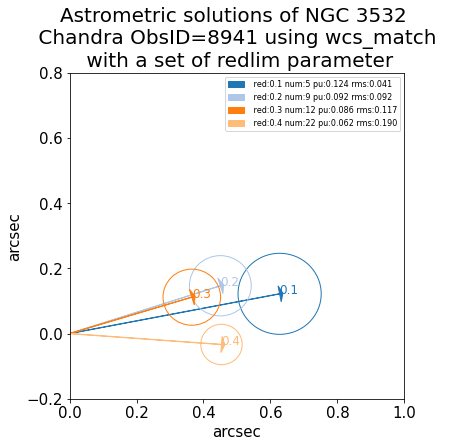

In [5]:
import matplotlib.pyplot as plt
#rho = 0.02182363072478699

fig, axs = plt.subplots(1,1, figsize=(6,6))
#axs = axs.flatten()
#for obsid, i, lims in zip(obsids, range(5), [[-1., 0.5 , -1, .5], [0, 1.5, -0.75, 0.75], [0, 1.5, -1.5, 0], [0, 2, -1, 1], [0, 2, 0, 2]]):
    
    #df_s = df[(df['obsid']==obsid)]
    
axs.set(xlim=(0, 1), ylim=(-0.2,0.8))

colors = iter([plt.cm.tab20(i) for i in range(20)])


x0, y0 = 0, 0 

del_ras, del_decs, rms_ress, residlims, astro_pus, num_srcs
    
for d_ra, d_dec, res, rms,pu, num,color in zip(del_ras, del_decs, residlims, rms_ress, astro_pus, num_srcs, colors):
    #p = (1.-np.exp(-rho*np.pi*res**2))*tot
    axs.arrow(x0, y0, d_ra, d_dec, head_width=0.05, head_length=0.01,fc=color,  ec=color,label=' red:'+str(res)+' num:'+str(num)+' pu:'+str(format(pu, '.3f'))+' rms:'+str(format(rms,'.3f')))
    circle = plt.Circle((d_ra, d_dec), pu, fc='none',ec=color, color = color, linewidth=1,alpha=1)
    axs.add_artist(circle)  
    axs.text(d_ra, d_dec,str(res),color=color,alpha=1.,fontsize=12)

axs.legend(fontsize=8)
axs.set_title('Astrometric solutions of NGC 3532 \n Chandra ObsID=8941 using wcs_match \n with a set of redlim parameter',fontsize=20)
axs.set_xlabel('arcsec',fontsize=15)
axs.set_ylabel('arcsec',fontsize=15)
axs.tick_params(axis='x', labelsize=15)
axs.tick_params(axis='y', labelsize=15)
#plt.show()
#plt.savefig('NGC3532_astro.eps')

In [5]:

# compare to previous and other resid results 

#df_pre = pd.read_csv('/Users/yanghui/Desktop/Research/2019/MUWCLASS_Project/ML/ML_pipelines_merge/MUWCLASS_pipeline_github/MUWCLASS_prepare_NGC3532/data/NGC3532_MW_clean.csv')

df = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_0.2_5_20_MW_clean.csv')

for cat, iden in zip(['gaia','2mass','catwise','unwise','allwise','vphas'], ['EDR3Name_gaia','_2MASS_2mass','objID_catwise','objID_unwise','AllWISE_allwise','sourceID_vphas']):
    
    df['flag_cp_compare_'+cat] = ''
    
    for res2 in [0.1, 0.3, 0.4]:
        df2 = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_{res2}_5_20_MW_clean.csv')

        #df_compare = pd.merge(df[['name',iden,'cp_flag_'+cat]], df2[['name',iden,'cp_flag_'+cat]], on=['name','name'],how='inner')
        
        #df_dif = df_compare[((~df_compare[iden+'_x'].isnull()) | (~df_compare[iden+'_y'].isnull()))  & (df_compare[iden+'_x']!=df_compare[iden+'_y'])]
        
        df_com = df[['name',iden,'cp_flag_'+cat]].merge(df2[['name',iden,'cp_flag_'+cat]], how = 'inner' ,indicator=False)
        
        df.loc[~df.name.isin(df_com.name), 'flag_cp_compare_'+cat] = df.loc[~df.name.isin(df_com.name), 'flag_cp_compare_'+cat] + str(res2)[-1]
        
df.to_csv(f'{data_dir}/Astrometry/{field_name}_0.2_5_20_clean_flag.csv', index=False)


In [6]:
pd.set_option("display.precision", 10)
df_MW = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_0.2_5_20_clean_flag.csv')
df_MW_pre = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_0.2_5_20_clean_flag_pre.csv')
#print(df_MW.columns[500:600])
#print(df_MW_pre.columns)
print(len(df_MW),len(df_MW_pre))
#cols_check = ['ra','dec','ra_cor','PU_kim95','PU','EDR3Name_gaia','cp_flag_gaia','_rs_gaia','X_PU_2mass','_rs_2mass']
cols_check = ['EDR3Name_gaia','cp_flag_gaia','_2MASS_2mass','cp_flag_2mass','objID_catwise','cp_flag_catwise',\
              'objID_unwise','cp_flag_unwise','AllWISE_allwise','cp_flag_allwise','VPHASDR2_vphas','cp_flag_vphas']
#cols_check = ['_r_gaia','_r_2mass','_r_catwise','_r_unwise','_r_allwise','_r_vphas']
#cols_check = ['flag_cp_compare_'+c for c in ['gaia','2mass','catwise','unwise','allwise','vphas']]    
#'''
for col in cols_check:
    
    df_comb = pd.merge(df_MW[['name',col]], df_MW_pre[['name',col]], on='name',how='inner')
    if len(df_comb[(df_comb[col+'_x']!=df_comb[col+'_y']) & (~df_comb[col+'_x'].isnull()) & (~df_comb[col+'_y'].isnull())])>0:
        print(col, len(df_comb[(df_comb[col+'_x']!=df_comb[col+'_y']) & (~df_comb[col+'_x'].isnull()) & (~df_comb[col+'_y'].isnull())]))
        print(df_comb[(df_comb[col+'_x']!=df_comb[col+'_y']) & (~df_comb[col+'_x'].isnull()) & (~df_comb[col+'_y'].isnull())][[col+'_x',col+'_y']])
    else:
        print(col, ' same')
#'''
df_comb = pd.merge(df_MW, df_MW_pre, on='name',how='inner')

#print(df_comb[(df_comb['cp_flag_gaia_x']!=df_comb['cp_flag_gaia_y']) & (~df_comb['cp_flag_gaia_x'].isnull()) & (~df_comb['cp_flag_gaia_y'].isnull())][['cp_flag_gaia_x','cp_flag_gaia_y','_r_gaia_x','_r_gaia_y','_r2_gaia_x','_r2_gaia_y','X_PU_gaia_x','X_PU_gaia_y']])

#print(df_comb[(df_comb['cp_flag_gaia_x']==2) & (df_comb['cp_flag_gaia_y']==0) & (~df_comb['cp_flag_gaia_x'].isnull()) & (~df_comb['cp_flag_gaia_y'].isnull())][['cp_flag_gaia_x','cp_flag_gaia_y','_r_gaia_x','_r_gaia_y','_r2_gaia_x','_r2_gaia_y','X_PU_gaia_x','X_PU_gaia_y']])

#print(df_comb[(df_comb['cp_flag_vphas_x']!=df_comb['cp_flag_vphas_y']) & (~df_comb['cp_flag_vphas_x'].isnull()) & (~df_comb['cp_flag_vphas_y'].isnull())][['cp_flag_vphas_x','cp_flag_vphas_y','_r_vphas_x','_r_vphas_y','_r2_vphas_x','_r2_vphas_y','X_PU_vphas_x','X_PU_vphas_y']])

print(df_comb[(df_comb['cp_flag_vphas_x']==2) & (df_comb['cp_flag_vphas_y']==0) & (~df_comb['cp_flag_vphas_x'].isnull()) & (~df_comb['cp_flag_vphas_y'].isnull())][['cp_flag_vphas_x','cp_flag_vphas_y','_r_vphas_x','_r_vphas_y','_r2_vphas_x','_r2_vphas_y','X_PU_vphas_x','X_PU_vphas_y']])

#print(df_comb[(df_comb['cp_flag_unwise_x']==2) & (df_comb['cp_flag_unwise_y']==0) & (~df_comb['cp_flag_unwise_x'].isnull()) & (~df_comb['cp_flag_unwise_y'].isnull())][['cp_flag_unwise_x','cp_flag_unwise_y','_r_unwise_x','_r_unwise_y','_r2_unwise_x','_r2_unwise_y','X_PU_unwise_x','X_PU_unwise_y']])

#print(df_comb[(df_comb['cp_flag_2mass_x']==2) & (df_comb['cp_flag_2mass_y']==0) & (~df_comb['cp_flag_2mass_x'].isnull()) & (~df_comb['cp_flag_2mass_y'].isnull())][['cp_flag_2mass_x','cp_flag_2mass_y','_r_2mass_x','_r_2mass_y','_r2_2mass_x','_r2_2mass_y','X_PU_2mass_x','X_PU_2mass_y']])


132 132
EDR3Name_gaia  same
cp_flag_gaia  same
_2MASS_2mass  same
cp_flag_2mass  same
objID_catwise  same
cp_flag_catwise  same
objID_unwise  same
cp_flag_unwise  same
AllWISE_allwise  same
cp_flag_allwise  same
VPHASDR2_vphas  same
cp_flag_vphas  same
Empty DataFrame
Columns: [cp_flag_vphas_x, cp_flag_vphas_y, _r_vphas_x, _r_vphas_y, _r2_vphas_x, _r2_vphas_y, X_PU_vphas_x, X_PU_vphas_y]
Index: []


In [90]:
df_MW = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_0.2_5_20_clean_flag.csv')

df_MW.loc[df_MW['cp_flag_gaia']==2, 'cp_flag_gaia'] = 0

df_MW.loc[df_MW['cp_flag_vphas']==2, 'cp_flag_vphas'] = 0

df_MW.to_csv(f'{data_dir}/Astrometry/{field_name}_0.2_5_20_clean_flag.csv',index=False)

In [7]:
df_gaia = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_0.2_5_20_clean_flag.csv')

#print(df_gaia.EDR3Name_gaia)
#df_gaia['Source_gaia'] = df_gaia.apply(lambda row: np.nan if pd.isnull(row.EDR3Name_gaia) else np.int64(row.EDR3Name_gaia[10:]), axis=1)
Gaia_counterparts(df_gaia,data_dir, field_name)
#print(df_gaia.Source_gaia)

INFO: Query finished. [astroquery.utils.tap.core]
(61540, 10)
132
132
(101, 13)
INFO: Query finished. [astroquery.utils.tap.core]
(11683, 19)
132
132
(34, 22)


In [8]:
df_gaia = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_0.2_5_20_clean_flag.csv')

for cat in ['2mass', 'allwise']:
    df_MW = pd.read_csv(f'{data_dir}/{field_name}_'+cat+'_gaia.csv')
    df_MW = df_MW.add_suffix('_gaia')
    df_MW = df_MW.rename(columns= {'_q_gaia': '_q'} )
    df_gaia = pd.merge(df_gaia, df_MW, how='outer', on=['_q'])
    

for i in df.index:
    flags = []
    for cat,label in zip(['gaia','2mass','catwise','unwise','allwise','vphas'], ['g','2','cw','uw','aw','v']):
        if pd.notna(df_gaia.loc[i,'flag_cp_compare_'+cat]) or ((df_gaia.loc[i, 'cp_flag_'+cat] <8) & (df_gaia.loc[i, 'cp_flag_'+cat] !=0)):
            flags.append(label)
        
    for cat,label in zip(['2mass_gaia','allwise_gaia'], ['2_g','aw_g']):
        if ((df_gaia.loc[i, 'cp_flag_'+cat] <8) & (df_gaia.loc[i, 'cp_flag_'+cat] !=0)):
            flags.append(label)
        
    df_gaia.loc[i,"cp_conf_flag"] = ",".join(flags)

df_gaia.to_csv(f'{data_dir}/{field_name}_MW_clean_update.csv',index=False)

In [19]:
pd.set_option("display.precision", 10)
df_MW = pd.read_csv(f'{data_dir}/{field_name}_MW_clean_update.csv')
df_MW_pre = pd.read_csv(f'{data_dir}/{field_name}_MW_clean_update_pre.csv')
print(df_MW.columns[100:200])
#print(df_MW_pre.columns)
print(len(df_MW),len(df_MW_pre))
#cols_check = ['ra','dec','ra_cor','PU_kim95','PU','EDR3Name_gaia','cp_flag_gaia','_rs_gaia','X_PU_2mass','_rs_2mass']
cols_check = ['EDR3Name_gaia','cp_flag_gaia','_2MASS_2mass','cp_flag_2mass','objID_catwise','cp_flag_catwise',\
             'objID_unwise','cp_flag_unwise','AllWISE_allwise','cp_flag_allwise','VPHASDR2_vphas','cp_flag_vphas',\
             'Jmag_2mass','Jmag_2mass_gaia']
#cols_check = ['_r_gaia','_r_2mass','_r_catwise','_r_unwise','_r_allwise','_r_vphas']
#cols_check = ['cp_conf_flag','PU','_r_gaia']    
for col in cols_check:
    
    df_comb = pd.merge(df_MW, df_MW_pre, on='name',how='inner')
    if len(df_comb[((df_comb[col+'_x']!=df_comb[col+'_y']) & (~df_comb[col+'_x'].isnull()) & (~df_comb[col+'_y'].isnull())) | ((df_comb[col+'_x'].isnull()) & (~df_comb[col+'_y'].isnull())) | ((~df_comb[col+'_x'].isnull()) & (df_comb[col+'_y'].isnull()))])>0:
        print(col, len(df_comb[((df_comb[col+'_x']!=df_comb[col+'_y']) & (~df_comb[col+'_x'].isnull()) & (~df_comb[col+'_y'].isnull())) | ((df_comb[col+'_x'].isnull()) & (~df_comb[col+'_y'].isnull())) | ((~df_comb[col+'_x'].isnull()) & (df_comb[col+'_y'].isnull()))]))
        print(df_comb[((df_comb[col+'_x']!=df_comb[col+'_y']) & (~df_comb[col+'_x'].isnull()) & (~df_comb[col+'_y'].isnull())) | ((~df_comb[col+'_x'].isnull()) & (df_comb[col+'_y'].isnull())) | ((df_comb[col+'_x'].isnull()) & (~df_comb[col+'_y'].isnull()))][[col+'_x',col+'_y']])
    else:
        print(col, ' same')

#print(df_comb[(df_comb['cp_conf_flag_x']!=df_comb['cp_conf_flag_y']) & (~df_comb['cp_conf_flag_x'].isnull()) & (~df_comb['cp_conf_flag_y'].isnull()) ][['cp_conf_flag_x','cp_conf_flag_y','cp_flag_gaia_x','cp_flag_gaia_y','flag_cp_compare_gaia_x','flag_cp_compare_gaia_y']])
#print(df_comb[(df_comb['cp_conf_flag_x']!=df_comb['cp_conf_flag_y'])  ][['cp_conf_flag_x','cp_conf_flag_y','cp_flag_gaia_x','cp_flag_gaia_y','flag_cp_compare_gaia_x','flag_cp_compare_gaia_y']])

Index(['e_pscol_gaia', 'RApscolCorr_gaia', 'DEpscolCorr_gaia',
       'PlxpscolCorr_gaia', 'pmRApscolCorr_gaia', 'pmDEpscolCorr_gaia',
       'MatchObsA_gaia', 'Nper_gaia', 'amax_gaia', 'MatchObs_gaia',
       'NewMatchObs_gaia', 'MatchObsrm_gaia', 'IPDgofha_gaia', 'IPDgofhp_gaia',
       'IPDfmp_gaia', 'IPDfow_gaia', 'RUWE_gaia', 'SDSk1_gaia', 'SDSk2_gaia',
       'SDSk3_gaia', 'SDSk4_gaia', 'SDMk1_gaia', 'SDMk2_gaia', 'SDMk3_gaia',
       'SDMk4_gaia', 'Dup_gaia', 'o_Gmag_gaia', 'FG_gaia', 'e_FG_gaia',
       'RFG_gaia', 'Gmag_gaia', 'e_Gmag_gaia', 'o_BPmag_gaia', 'FBP_gaia',
       'e_FBP_gaia', 'RFBP_gaia', 'BPmag_gaia', 'e_BPmag_gaia', 'o_RPmag_gaia',
       'FRP_gaia', 'e_FRP_gaia', 'RFRP_gaia', 'RPmag_gaia', 'e_RPmag_gaia',
       'NBPcont_gaia', 'NBPblend_gaia', 'NRPcont_gaia', 'NRPblend_gaia',
       'Mode_gaia', 'E_BP_RP__gaia', 'BP-RP_gaia', 'BP-G_gaia', 'G-RP_gaia',
       'RVDR2_gaia', 'e_RVDR2_gaia', 'o_RVDR2_gaia', 'Tefftemp_gaia',
       'loggtemp_gaia', '__Fe_H_temp_ga

In [21]:

df_MW_update = pd.read_csv(f'{data_dir}/{field_name}_MW_clean_update.csv')

df_save = prepare_cols(df_MW_update, cp_thres=-4, vphas=True,gaiadata=True)

In [4]:
df_save.to_csv('df_test.csv',index=False)

df_MW_update = pd.read_csv(f'{data_dir}/{field_name}_MW_clean_update.csv')
df_MW_update_sig = df_MW_update[df_MW_update.significance>5.]
df_MW_update_sig.sort_values(by='significance', ascending=False).to_csv(f'{data_dir}/{field_name}_MW_clean_update_sig.csv',index=False)

sig_astro=5
count_astro=20
cat = 'gaia'
data_dir = './data'
field_name = 'NGC3532'
residlims = [0.1, 0.2, 0.3, 0.4]
residlims_copy = residlims.copy()
for res1 in [0.1, 0.2, 0.3, 0.4]:
    
    df1 = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_{res1}_{sig_astro}_{count_astro}_{cat}_clean.csv')
    residlims_copy.remove(res1)
    
    for res2 in residlims_copy:
        print(res1,'vs', res2)
        df2 = pd.read_csv(f'{data_dir}/Astrometry/{field_name}_{res2}_{sig_astro}_{count_astro}_{cat}_clean.csv')
    
        
        df_compare = pd.merge(df1[['name', 'EDR3Name_gaia']], df2[['name','EDR3Name_gaia']], on=['name','name'],how='inner')
        df_compare['EDR3Name_gaia_x'] = df_compare['EDR3Name_gaia_x'].str[10:]
        df_compare['EDR3Name_gaia_y'] = df_compare['EDR3Name_gaia_y'].str[10:]
        #print(df_compare)
    
        df_dif = df_compare[((~df_compare.EDR3Name_gaia_x.isnull()) | (~df_compare.EDR3Name_gaia_y.isnull()))  & (df_compare.EDR3Name_gaia_x!=df_compare.EDR3Name_gaia_y)]
        print(len(df_compare), len(df_dif), len(df_dif[df_dif.EDR3Name_gaia_x.isnull()]), len(df_dif[df_dif.EDR3Name_gaia_y.isnull()]))
        print(df_dif)
    
    
        